# Model v19_attention_255

Path images, roughness metric = 1 second ahead, k-means 4, data split within sessions, images with attention region.

## Set-up

In [1]:
!pip install wandb

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [5]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-4')

wandb: Currently logged in as: gabrielag (use `wandb login --relogin` to force relogin)


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [7]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'attention_region', 'v19')
image_path = '/gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255'
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [8]:
df = pd.read_csv(os.path.join(label_path, 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
df = df.filter(items=['image_mask', 'group_4', 'dataset'])

# Categorical data
df['group_4'] = df['group_4'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image_mask', 'group_4', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image_mask', 'group_4', 'is_valid'])

#### Balance classes

In [9]:
# Training set
group_0 = train[train['group_4'] == '0']
group_1 = train[train['group_4'] == '1']
group_2 = train[train['group_4'] == '2']
group_3 = train[train['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

1648
1267
529
145


In [10]:
group_0 = group_0[:1000]
group_1 = group_1[:1000]

train_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_4'] == '0']))
print(len(train_balanced[train_balanced['group_4'] == '1']))
print(len(train_balanced[train_balanced['group_4'] == '2']))
print(len(train_balanced[train_balanced['group_4'] == '3']))

2674
1000
1000
529
145


Balanced training set composition:
- 0: 37.40%
- 1: 37.40%
- 2: 19.78%
- 3: 5.42%

Validation set:
- 0: 298/797 = 37.40%
- 1: 298/797 = 37.40%
- 2: 150/797: 18.82%
- 3: 50/797 = 6.27%

In [11]:
# Validation set
group_0_v = valid[valid['group_4'] == '0']
group_1_v = valid[valid['group_4'] == '1']
group_2_v = valid[valid['group_4'] == '2']
group_3_v = valid[valid['group_4'] == '3']

print(len(group_0_v))
print(len(group_1_v))
print(len(group_2_v))
print(len(group_3_v))

366
333
150
51


In [12]:
group_0_v = group_0_v[:298]
group_1_v = group_1_v[:298]

valid_balanced = group_0_v.append(group_1_v).append(group_2_v).append(group_3_v)

print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_4'] == '0']))
print(len(valid_balanced[valid_balanced['group_4'] == '1']))
print(len(valid_balanced[valid_balanced['group_4'] == '2']))
print(len(valid_balanced[valid_balanced['group_4'] == '3']))

797
298
298
150
51


In [13]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

3471
2674
797


In [14]:
df_balanced.head()

,image_mask,group_4,is_valid
0,969905035s184ms.png,0,False
1,970588340s260ms.png,0,False
5,969902113s258ms.png,0,False
6,970588196s250ms.png,0,False
7,970588218s272ms.png,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [15]:
bs = 64

In [16]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_4')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [17]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2674 2674
797 797


In [18]:
print(data.classes)

['0', '1', '2', '3']


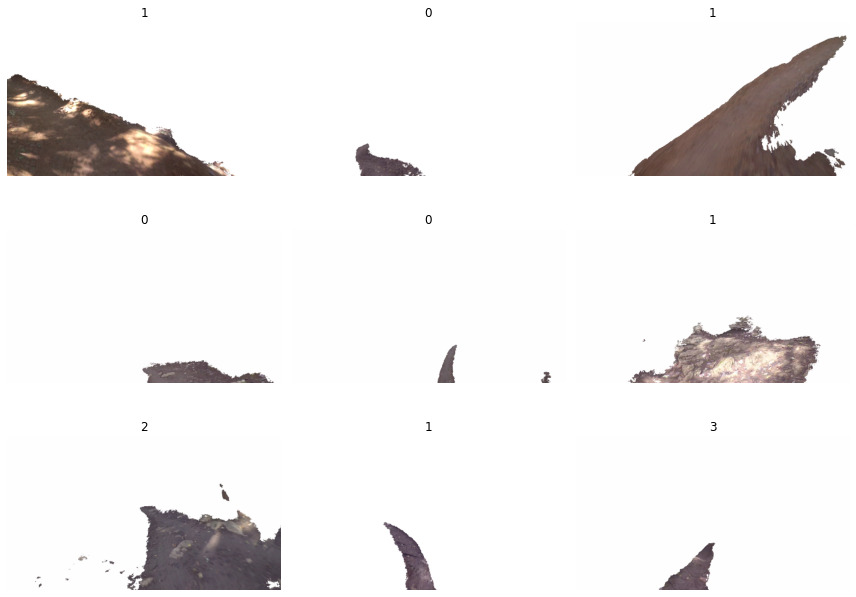

In [19]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [20]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


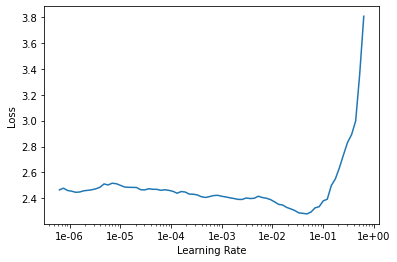

In [22]:
learn.recorder.plot()

In [23]:
lr = 0.01

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.154447,2.102568,0.409034,13:27
1,1.703183,2.175878,0.329987,11:04
2,1.540103,1.369579,0.422836,10:38
3,1.403200,1.385180,0.371393,10:48
4,1.328896,1.272333,0.404015,10:54


Better model found at epoch 0 with valid_loss value: 2.1025683879852295.
Better model found at epoch 2 with valid_loss value: 1.3695789575576782.
Better model found at epoch 4 with valid_loss value: 1.2723329067230225.
Loaded best saved model from /content/wandb/run-20210108_154701-2mj610z0/files/bestmodel.pth


In [25]:
learn.save(os.path.join(folder_path, 'v19-attention-255-stage-1'))

In [26]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.342340,1.520348,0.348808,10:50
1,1.338886,1.342785,0.393977,10:42


Better model found at epoch 0 with valid_loss value: 1.5203477144241333.
Better model found at epoch 1 with valid_loss value: 1.3427848815917969.
Loaded best saved model from /content/wandb/run-20210108_154701-2mj610z0/files/bestmodel.pth


In [27]:
learn.load(os.path.join(folder_path, 'v19-attention-255-stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (2674 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
0,0,0,0,0
Path: /gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255;

Valid: LabelList (797 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
0,0,0,0,0
Path: /gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): B

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

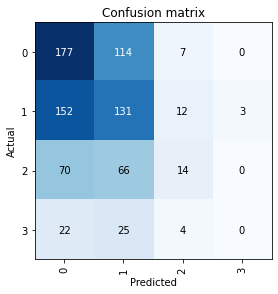

In [29]:
interp.plot_confusion_matrix()

#### Fine-tune

In [30]:
learn.load(os.path.join(folder_path, 'v19-attention-255-stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (2674 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
0,0,0,0,0
Path: /gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255;

Valid: LabelList (797 items)
x: ImageList
Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480),Image (3, 270, 480)
y: CategoryList
0,0,0,0,0
Path: /gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): B

In [31]:
learn.data.batch_size = 16

In [32]:
learn.data.batch_size

16

In [33]:
learn.unfreeze()

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20210108_154701-2mj610z0/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


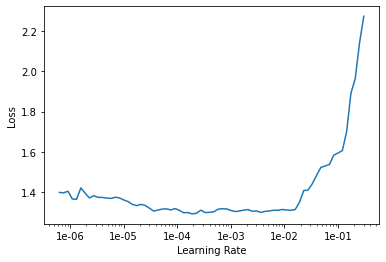

In [35]:
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.302912,1.280848,0.410289,10:46
1,1.281358,1.276052,0.406524,10:47
2,1.248937,1.251770,0.417817,10:45
3,1.209398,1.251528,0.425345,10:41
4,1.191155,1.245507,0.412798,11:06


Better model found at epoch 0 with valid_loss value: 1.2808476686477661.
Better model found at epoch 1 with valid_loss value: 1.276051640510559.
Better model found at epoch 2 with valid_loss value: 1.2517695426940918.
Better model found at epoch 3 with valid_loss value: 1.2515283823013306.
Better model found at epoch 4 with valid_loss value: 1.2455066442489624.
Loaded best saved model from /content/wandb/run-20210108_154701-2mj610z0/files/bestmodel.pth


In [37]:
learn.save(os.path.join(folder_path, 'v19-attention-255-stage-2'))

In [38]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.231359,1.246775,0.380176,11:11
1,1.219529,1.276568,0.417817,11:09


Better model found at epoch 0 with valid_loss value: 1.2467750310897827.
Loaded best saved model from /content/wandb/run-20210108_154701-2mj610z0/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v19-attention-255-stage-2'))

In [40]:
learn.freeze()

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

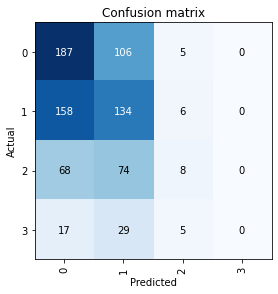

In [42]:
interp.plot_confusion_matrix()

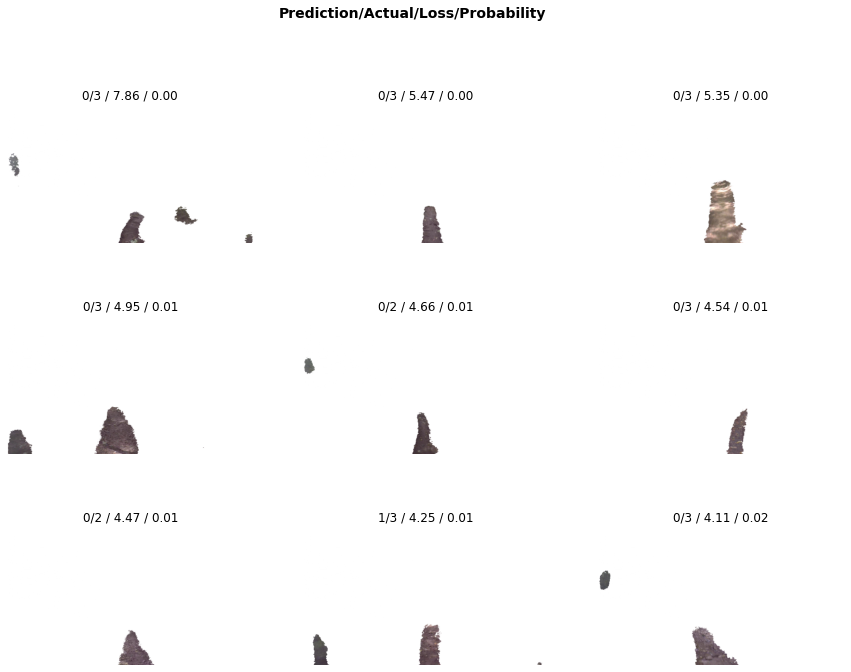

In [43]:
interp.plot_top_losses(9, figsize=(15,11))